### Data Splitting
The data proportion would be 70% training, 15% validation, 15% testing

In [2]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split


#### Configuration
---

In [3]:

ORIGINAL_DATASET = r"C:\Users\USER\Documents\Thesis Dataset\Original Dataset"

# Defining path variables for splitting the data
BASE_OUTPUT = r"C:\Users\USER\Documents\Thesis Dataset\Processed Dataset"
TRAIN_DIR = os.path.join(BASE_OUTPUT, "train")
VAL_DIR   = os.path.join(BASE_OUTPUT, "val")
TEST_DIR  = os.path.join(BASE_OUTPUT, "test")

# Splitting percentage or proportion
train_ratio = 0.70
val_ratio   = 0.15
test_ratio  = 0.15

IMG_EXTENSIONS = (".jpg", ".jpeg", ".png")

#### Clean and Create Directories 

Remove old processed data to avoid duplicates and create paths for training, validation and testing

In [4]:

# Deletes an already existed file
if os.path.exists(BASE_OUTPUT):
    shutil.rmtree(BASE_OUTPUT)

# Creates the directory for the path variables
for dir_path in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    os.makedirs(dir_path, exist_ok=True)


#### SPLIT & COPY FUNCTION

In [5]:

def split_and_copy(class_images, train_path, val_path, test_path):
    """Split the list of image paths into train/val/test and copy once."""
    if len(class_images) < 3:
        print(f"Folder is Empty or does not have an image: {os.path.basename(train_path)}")
        return

    random.shuffle(class_images)

    # Splitting Data: Train vs Temp (Val+Test)
    train_imgs, temp_imgs = train_test_split(
        class_images, test_size=(1 - train_ratio), random_state=42
    )
    # Splitting the Temp: Validation and Test
    val_imgs, test_imgs = train_test_split(
        temp_imgs,
        test_size=(test_ratio / (test_ratio + val_ratio)),
        random_state=42,
    )

    # Copy each image
    for img in train_imgs:
        shutil.copy2(img, train_path)
    for img in val_imgs:
        shutil.copy2(img, val_path)
    for img in test_imgs:
        shutil.copy2(img, test_path)


#### Main loop
Loop for each plant to be splitted and copy to the processed folder

split and copy function is used

In [6]:

for crop_type in sorted(os.listdir(ORIGINAL_DATASET)):
    crop_path = os.path.join(ORIGINAL_DATASET, crop_type)
    if not os.path.isdir(crop_path):
        continue

    for disease_class in sorted(os.listdir(crop_path)):
        class_path = os.path.join(crop_path, disease_class)
        if not os.path.isdir(class_path):
            continue

        # Collect image files in each disease class
        images = [
            os.path.join(class_path, f)
            for f in os.listdir(class_path)
            if f.lower().endswith(IMG_EXTENSIONS)
        ]

        # Output directories
        train_out = os.path.join(TRAIN_DIR, crop_type, disease_class)
        val_out   = os.path.join(VAL_DIR, crop_type, disease_class)
        test_out  = os.path.join(TEST_DIR, crop_type, disease_class)

        os.makedirs(train_out, exist_ok=True)
        os.makedirs(val_out, exist_ok=True)
        os.makedirs(test_out, exist_ok=True)

        # Using the copy and splitting function
        split_and_copy(images, train_out, val_out, test_out)

        # Checking performance per disease in each crop type 
        print(f"{crop_type}/{disease_class}: {len(images)} images processed")

print("✅ Dataset successfully split into 70% Train, 15% Validation, 15% Test!")

Banana_Leaf_Disease_Dataset_Bangladesh/Healthy: 1108 images processed
Banana_Leaf_Disease_Dataset_Bangladesh/Panama Disease: 835 images processed
Banana_Leaf_Disease_Dataset_Bangladesh/Yellow and Black Sigatoka: 2597 images processed
Banana_Leaf_Disease_Dataset_Bangladesh/cordana: 442 images processed
Banana_Leaf_Disease_Dataset_Bangladesh/pestalotiopsis: 117 images processed
Coconut Tree Disease Dataset/Bud Root Dropping: 514 images processed
Coconut Tree Disease Dataset/Bud Rot: 470 images processed
Coconut Tree Disease Dataset/Gray Leaf Spot: 2135 images processed
Coconut Tree Disease Dataset/Healthy_Leaves: 123 images processed
Coconut Tree Disease Dataset/Leaf Rot: 1673 images processed
Coconut Tree Disease Dataset/WCLWD_DryingofLeaflets: 1078 images processed
Coconut Tree Disease Dataset/WCLWD_Flaccidity: 1069 images processed
Coconut Tree Disease Dataset/WCLWD_Yellowing: 1084 images processed
Sugarcane Leaf Disease Dataset/Healthy: 522 images processed
Sugarcane Leaf Disease Dat

### Data Augmentation
We will manipulate the data using **horizontal flip**, **vertical flip**, **brighten**, **darken**, **rotate**, and **contrast**.

In [10]:
import os
import random
from pathlib import Path
from PIL import Image, ImageEnhance


#### ⚙️ Configurationn

In [11]:

# Original training set folder directory
TRAIN_DIR = r"C:\Users\USER\Documents\Thesis Dataset\Processed Dataset\train"

# New folder for augmented images
AUGMENT_DIR = r"C:\Users\USER\Documents\Thesis Dataset\Processed Dataset\train_augmented"

IMG_EXTENSIONS = (".jpg", ".jpeg", ".png")

ROTATE_ANGLE = 90        # maximum rotation angle (+/-)
BRIGHTNESS_FACTOR = 1.5  # factor for brightening/darkening
CONTRAST_FACTOR  = 1.5   # factor for contrast adjustment

### 🧩 Data Augmentation Functions
Below are the different augmentation techniques used to diversify the training dataset:

| Function | Description |
|----------|-------------|
| `horizontal_flip` ↔️ | Flips the image **horizontally** (left ↔ right). |
| `vertical_flip` ↕️   | Flips the image **vertically** (top ↕ bottom). |
| `brighten` ☀️        | Increases the image **brightness** for lighter tones. |
| `darken` 🌑          | Decreases the image **brightness** for darker tones. |
| `rotate` 🔄          | Rotates the image by **±90 degrees** to simulate different orientations. |
| `adjust_contrast` 🎨 | Adjusts the image **contrast** to enhance or soften edges. |

> 💡 **Tip:**  
> Applying these augmentations helps the model generalize better and handle variations in lighting, orientation, and texture.


In [12]:
def horizontal_flip(img):
    return img.transpose(Image.FLIP_LEFT_RIGHT)

def vertical_flip(img):
    return img.transpose(Image.FLIP_TOP_BOTTOM)

def brighten(img):
    enhancer = ImageEnhance.Brightness(img)
    return enhancer.enhance(BRIGHTNESS_FACTOR)

def darken(img):
    enhancer = ImageEnhance.Brightness(img)
    return enhancer.enhance(1.0 / BRIGHTNESS_FACTOR)

def rotate(img):
    angle = random.uniform(-ROTATE_ANGLE, ROTATE_ANGLE)
    return img.rotate(angle, expand=True)

def adjust_contrast(img):
    enhancer = ImageEnhance.Contrast(img)
    return enhancer.enhance(CONTRAST_FACTOR)

AUGMENTATIONS = {
    "flipH": horizontal_flip,
    "flipV": vertical_flip,
    "bright": brighten,
    "dark": darken,
    "rotate": rotate,
    "contrast": adjust_contrast,  
}

#### Folders for the augmented data

In [13]:

for root, dirs, _ in os.walk(TRAIN_DIR):
    rel_path = os.path.relpath(root, TRAIN_DIR)
    new_path = os.path.join(AUGMENT_DIR, rel_path)
    os.makedirs(new_path, exist_ok=True)

#### The augmentation process loop

In [15]:
count_original = 0
count_augmented = 0

for root, _, files in os.walk(TRAIN_DIR):
    for file in files:
        if file.lower().endswith(IMG_EXTENSIONS):
            file_path = os.path.join(root, file)
            img = Image.open(file_path).convert("RGB")
            count_original += 1

            base_name, ext = os.path.splitext(file)
            rel_path = os.path.relpath(root, TRAIN_DIR)  
            save_base = os.path.join(AUGMENT_DIR, rel_path)

            # Applying all augmentations
            for aug_name, aug_func in AUGMENTATIONS.items():
                aug_img = aug_func(img)
                save_name = f"{base_name}_{aug_name}{ext}"
                save_path = os.path.join(save_base, save_name)
                aug_img.save(save_path)
                count_augmented += 1

print("✅ Augmentation complete!")
print(f"Original images processed: {count_original}")
print(f"New augmented images saved: {count_augmented}")
print(f"Augmented data location: {AUGMENT_DIR}")

✅ Augmentation complete!
Original images processed: 11026
New augmented images saved: 66156
Augmented data location: C:\Users\USER\Documents\Thesis Dataset\Processed Dataset\train_augmented


#### TESTING AND PRINTING IMAGES


=== Crop Type: Banana_Leaf_Disease_Dataset_Bangladesh ===


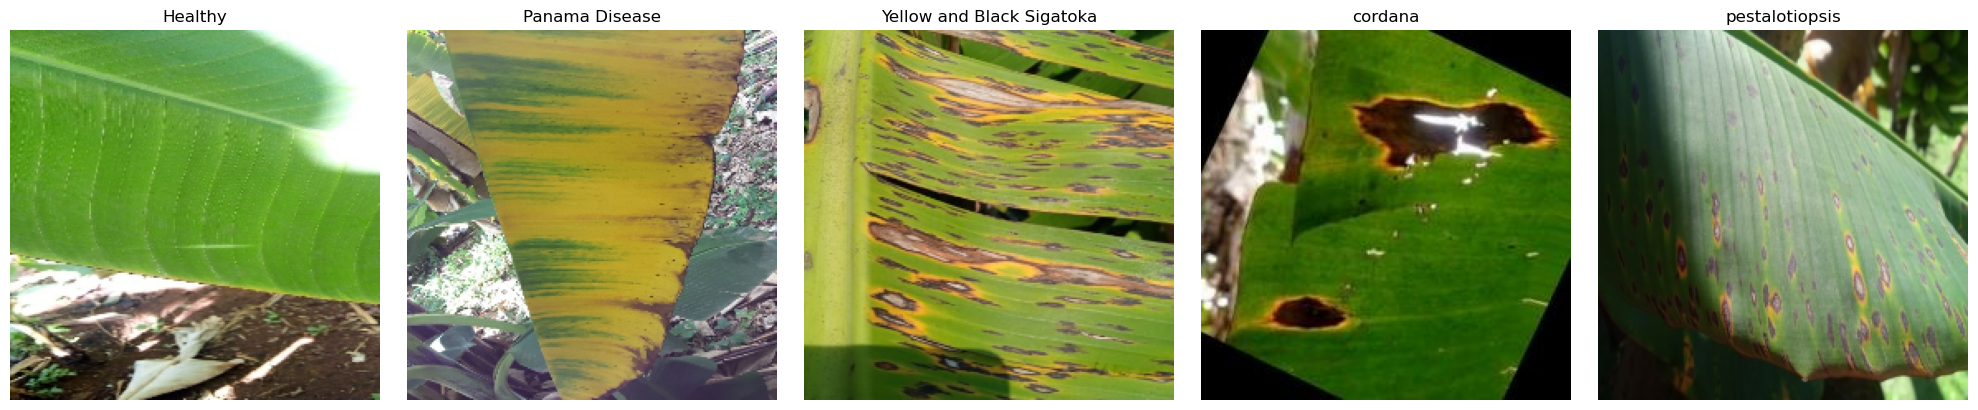


=== Crop Type: Coconut Tree Disease Dataset ===


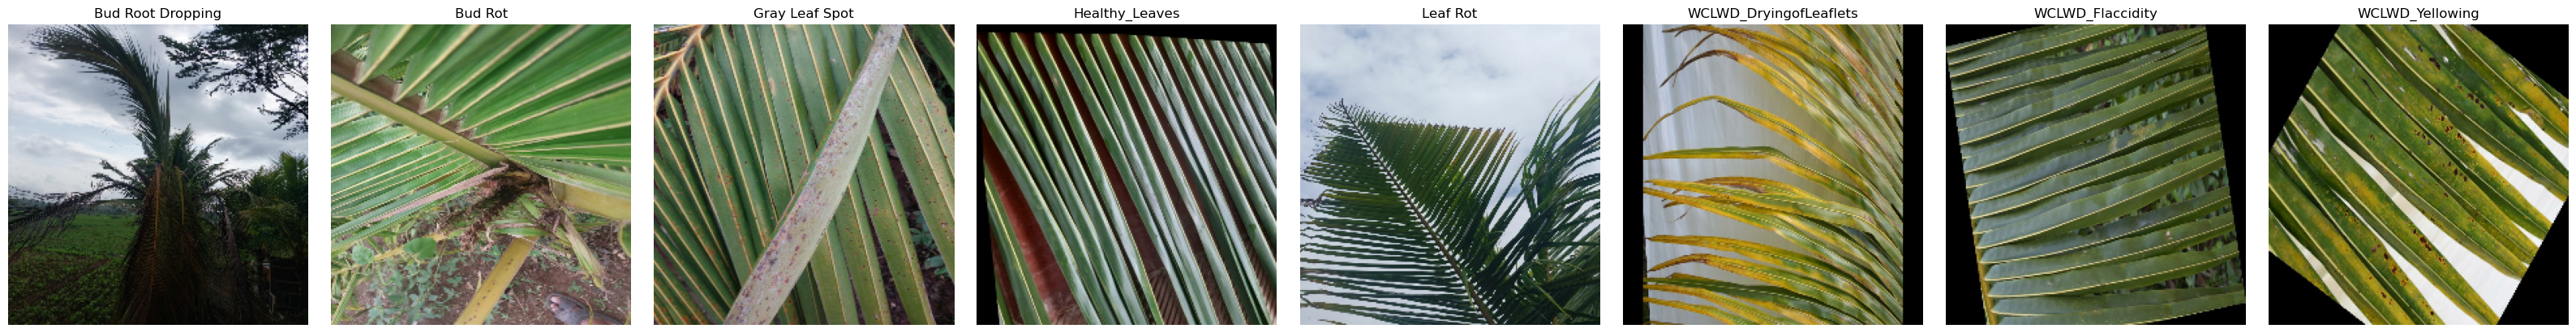


=== Crop Type: Sugarcane Leaf Disease Dataset ===


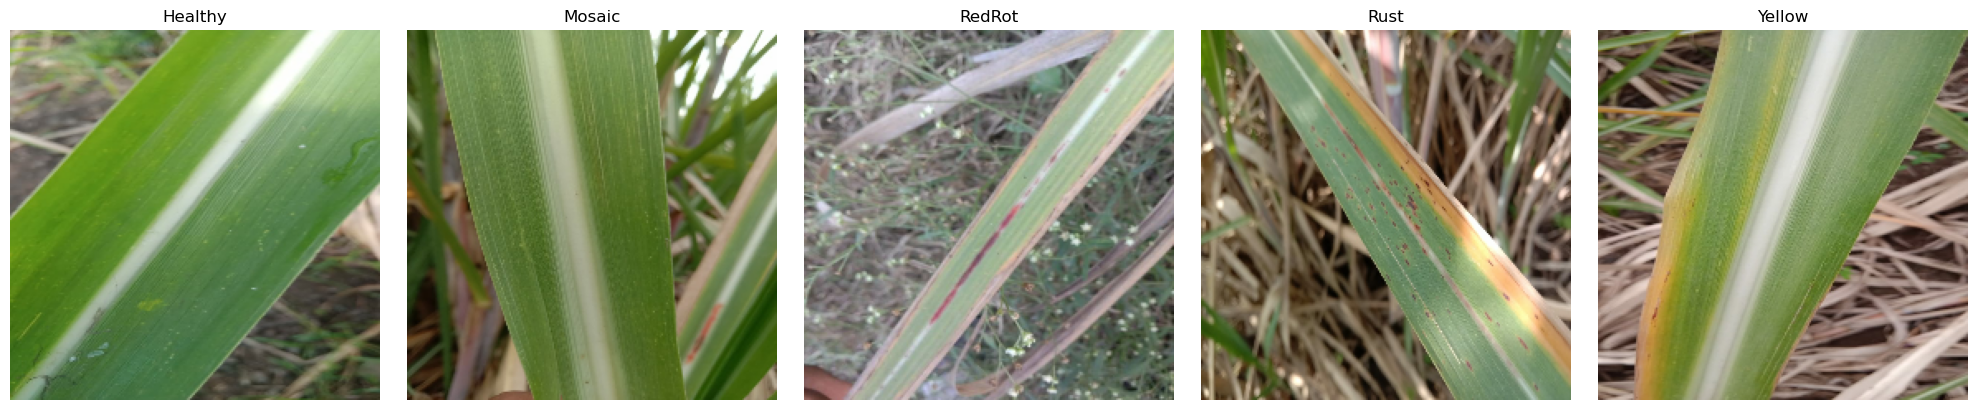

In [16]:
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt

# =========================
# CONFIGURATION
# =========================
TRAIN_AUGMENTED_DIR = r"C:\Users\USER\Documents\Thesis Dataset\Processed Dataset\train_augmented"
IMG_SIZE = (224, 224)   # Resize for display

# =========================
# DISPLAY FUNCTION
# =========================
def show_samples_per_class(train_augmented_dir):
    """
    Show one sample image per disease class for each crop type,
    using TensorFlow to load and display the images.
    """
    for crop in sorted(os.listdir(train_augmented_dir)):
        crop_path = os.path.join(train_augmented_dir, crop)
        if not os.path.isdir(crop_path):
            continue
        
        print(f"\n=== Crop Type: {crop} ===")
        disease_classes = [d for d in os.listdir(crop_path) if os.path.isdir(os.path.join(crop_path, d))]
        n_classes = len(disease_classes)
        
        plt.figure(figsize=(4*n_classes, 4))
        for i, disease in enumerate(sorted(disease_classes)):
            disease_path = os.path.join(crop_path, disease)
            # Pick a random image from this disease class
            img_files = [f for f in os.listdir(disease_path) if f.lower().endswith(('.jpg','.jpeg','.png'))]
            if not img_files:
                continue
            img_file = random.choice(img_files)
            img_path = os.path.join(disease_path, img_file)
            
            # Load and resize with TensorFlow
            img = tf.io.read_file(img_path)
            img = tf.image.decode_image(img, channels=3)
            img = tf.image.resize(img, IMG_SIZE)
            img = tf.cast(img, tf.uint8)  # ensure correct dtype for matplotlib
            
            # Plot
            plt.subplot(1, n_classes, i+1)
            plt.imshow(img.numpy())
            plt.title(f"{disease}", fontsize=12)
            plt.axis("off")
        
        plt.tight_layout()
        plt.show()

# =========================
# RUN THE DISPLAY
# =========================
show_samples_per_class(TRAIN_DIR)
